In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from sklearn.preprocessing import StandardScaler, minmax_scale
from scipy.stats import normaltest

from sklearn.impute import SimpleImputer

from workalendar.europe.united_kingdom import UnitedKingdom, UnitedKingdomNorthernIreland
import calendar

from astral.sun import sun
from astral import LocationInfo

from datetime import datetime, date

import featuretools as ft
from featuretools.primitives import Minute, Hour, Day, Month, Year, Weekday

from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sktime.datasets import load_arrow_head
# from sktime.utils.data_processing import from_nested_to_2d_array
from sktime.transformations.panel.rocket import Rocket
# from sktime.transformations.panel.shapelet_transform import BaseTransformer
# from sktime.transformations.panel.shapelets import ContractedShapeletTransform

### Log and Power Transformations in Practice

In [4]:
np.random.seed(0)
pts = 10000
vals = np.random.lognormal(0, 1.0, pts)

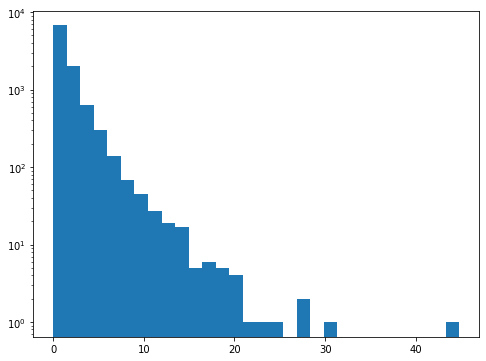

In [5]:
plt.figure(figsize=(8, 6))
plt.hist(vals, bins=30)
plt.yscale("log")

In [6]:
scaler = StandardScaler()
vals_ss = scaler.fit_transform(vals.reshape(-1, 1))
_, p = normaltest(vals_ss)
print(f"significance: {p[0]:.2}")

significance: 0.0


In [7]:
from sklearn.preprocessing import minmax_scale
vals_mm = minmax_scale(vals)
_, p = normaltest(vals_mm.squeeze())
print(f"significance: {p:.2f}")

significance: 0.00


In [8]:
log_transformed = np.log(vals)
_, p = normaltest(log_transformed)
print(f"significance: {p:.2f}")

significance: 0.46


### Imputation

In [9]:
data = [
    [7, 2, 3], 
    [4, np.nan, 6], 
    [10, 5, 9]
]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(data)

print(imp_mean.transform(data))

[[ 7.   2.   3. ]
 [ 4.   3.5  6. ]
 [10.   5.   9. ]]


### Holiday Features

In [10]:
UnitedKingdomNorthernIreland().holidays()

[(datetime.date(2022, 1, 1), 'New year'),
 (datetime.date(2022, 1, 3), 'New Year shift'),
 (datetime.date(2022, 3, 17), "Saint Patrick's Day"),
 (datetime.date(2022, 4, 15), 'Good Friday'),
 (datetime.date(2022, 4, 17), 'Easter Sunday'),
 (datetime.date(2022, 4, 18), 'Easter Monday'),
 (datetime.date(2022, 5, 2), 'Early May Bank Holiday'),
 (datetime.date(2022, 6, 2), 'Spring Bank Holiday'),
 (datetime.date(2022, 6, 3), 'Queen’s Platinum Jubilee bank holiday'),
 (datetime.date(2022, 7, 12), 'Battle of the Boyne'),
 (datetime.date(2022, 8, 29), 'Late Summer Bank Holiday'),
 (datetime.date(2022, 12, 25), 'Christmas Day'),
 (datetime.date(2022, 12, 26), 'Boxing Day'),
 (datetime.date(2022, 12, 26), 'Christmas Shift'),
 (datetime.date(2022, 12, 27), 'Boxing Day Shift')]

### Date Annotation

In [11]:
calendar.monthrange(2023, 1)

(6, 31)

### The Sun and Moon

In [12]:
CITY = LocationInfo("London", "England", "Europe/London", 51.5, -0.116)

def get_sunrise_dusk(current_date: datetime.date):
    s = sun(CITY.observer, date=current_date)
    sunrise = s['sunrise']
    dusk = s['dusk']
    return (sunrise - dusk).seconds / 3600

get_sunrise_dusk(datetime.now())

8.204444444444444

### Business Days

In [13]:
def get_business_days(current_date: datetime.date):
    last_day = calendar.monthrange(current_date.year, current_date.month)[1]
    rng = pd.date_range(current_date.replace(day=1), periods=last_day, freq='D')
    business_days = pd.bdate_range(rng[0], rng[-1])
    return len(business_days), last_day - len(business_days)

get_business_days(date.today())

(23, 8)

### Automated Feature Extraction

In [14]:
data = pd.DataFrame(
    {'Time': ['2014-01-01 01:41:50',
              '2014-01-01 02:06:50',
              '2014-01-01 02:31:50',
              '2014-01-01 02:56:50',
              '2014-01-01 03:21:50'],
     'Target': [0, 0, 0, 0, 1]}
)
data['index'] = data.index

In [15]:
data

,Time,Target,index
0,2014-01-01 01:41:50,0,0
1,2014-01-01 02:06:50,0,1
2,2014-01-01 02:31:50,0,2
3,2014-01-01 02:56:50,0,3
4,2014-01-01 03:21:50,1,4


In [16]:
es = ft.EntitySet('My EntitySet').add_dataframe(
    dataframe_name='main_data_table',
    index='index',
    dataframe=data,
    time_index='Time'
)

In [17]:
fm, features = ft.dfs(
    entityset=es, 
    target_dataframe_name='main_data_table', 
    trans_primitives=[Minute, Hour, Day, Month, Year, Weekday]
)

C:\Users\stakk\miniconda3\envs\timeseries\lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:161: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


### Automated Feature Extraction (tsfresh)

In [18]:
# https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html
settings = ComprehensiveFCParameters()
# extract_features(data, column_id='Time', default_fc_parameters=settings)

### ROCKET

In [19]:
X_train, y_train = load_arrow_head(split="train", return_X_y=True)
X_train.head()

,dim_0
0,0 -1.963009 1 -1.957825 2 -1.95614...
1,0 -1.774571 1 -1.774036 2 -1.77658...
2,0 -1.866021 1 -1.841991 2 -1.83502...
3,0 -2.073758 1 -2.073301 2 -2.04460...
4,0 -1.746255 1 -1.741263 2 -1.72274...


In [20]:
X_train.size

36

In [21]:
rocket = Rocket(num_kernels=1000)
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)